In [12]:
# https://towardsdatascience.com/build-your-own-transformer-from-scratch-using-pytorch-84c850470dcb

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import math
import copy

In [13]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
        
    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
        attn_probs = torch.softmax(attn_scores, dim=-1)
        output = torch.matmul(attn_probs, V)
        return output
        
    def split_heads(self, x):
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)
        
    def combine_heads(self, x):
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)
        
    def forward(self, Q, K, V, mask=None):
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))
        
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        output = self.W_o(self.combine_heads(attn_output))
        return output

In [14]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

In [15]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()
        
        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe.unsqueeze(0))
        
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

In [16]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        attn_output = self.self_attn(x, x, x)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

In [17]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout):
        super(Transformer, self).__init__()
        self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)
        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.output_layer = nn.Linear(max_seq_length*d_model, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output)
        #print("enc_output.shape: ", enc_output.shape)
        # flatten the output of the last encoder layer
        enc_output = enc_output.view(enc_output.size(0), -1)
        #print("enc_output.shape: ", enc_output.shape)
        output = self.output_layer(enc_output)
        #print("output.shape: ", output.shape)
        return output

In [18]:
import torchtext
import pandas as pd
import time
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

df=pd.read_csv("Amazon-Deutsch-Dataset.csv")
df = df[["content", "rating"]]
df.rating= df.rating.str[0]
df = df.dropna()
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
tokenizer = get_tokenizer('spacy', language='de_core_news_sm')

# create iterator from tokenized df
def df_iterator_content(df):
    for _, row in df.iterrows():
        yield tokenizer(row['content'])

vocab = build_vocab_from_iterator(df_iterator_content(df))
vocab= torchtext.vocab.Vocab(vocab.freqs, min_freq=10)
vocab_size = len(vocab)
print(vocab_size)

3409lines [00:00, 4104.46lines/s]

2400


In [19]:
def get_vocab_idx(wordlist):
    return [vocab[token] for token in wordlist]

In [20]:
import torch
from torch.utils.data import Dataset

class AmazonDataset(Dataset):
    def __init__(self, df, word_count=500, vocab_size=10000):
        self.df = df
        self.word_count = word_count
        self.vocab_size = vocab_size
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        x= self.df.iloc[idx]["content"]
        y= self.df.iloc[idx]["rating"]
        y = int(y) - 1
        x = get_vocab_idx(tokenizer(x))
        # we need this because we need to have a fixed size input
        if len(x) > self.word_count:
            x=x[:self.word_count]
        else:
        # pad with zeros, in case the text is shorter than word_count
            x.extend([0]*(self.word_count-len(x)))
        x = torch.tensor(x)
        y= torch.tensor(y, dtype=torch.float)
        return x, y

amazon_dataset = AmazonDataset(df, word_count=50, vocab_size=vocab_size)
x,y=amazon_dataset[0]
print(x.shape)
print(y)

torch.Size([50])
tensor(4.)


In [21]:
# test the model
vocab_size = len(vocab)
word_count = 100
d_model = 16
num_heads = 2
num_layers = 1
d_ff = 32 # what is d_ff? --> feed forward layer size

model = Transformer(vocab_size,  d_model=d_model, num_heads=num_heads, num_layers=num_layers, d_ff=d_ff, max_seq_length=word_count, dropout=0.1)
dataset = AmazonDataset(df, word_count=word_count, vocab_size=vocab_size)
loader = torch.utils.data.DataLoader(dataset, batch_size=5, shuffle=True)

# check if model works
xb, yb = next(iter(loader))

print("yb", yb)
print("xb", xb.shape)

y_hat=model(xb)
print("y_hat", y_hat.shape)
# 2x5x32 ?????

yb tensor([1., 0., 3., 2., 0.])
xb torch.Size([5, 100])
y_hat torch.Size([5, 1])


In [22]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(device)

mps


In [23]:
#loss_func = torch.nn.L1Loss() # L1 Loss is used for regression, it computes the mean absolute error between the input and the target
loss_func = torch.nn.MSELoss() 
loss_func = lambda x,y: torch.mean(torch.abs(x-y))


def evaluate(model, dataloader):
    model.eval()
    sum_loss = 0
    with torch.no_grad():
        for idx, (xb, yb) in enumerate(dataloader):
            xb=xb.to(device)
            yb=yb.to(device)
            yb=yb[:,None]
            predicted_label = model(xb)
            loss=loss_func(predicted_label, yb)
            sum_loss += loss.item()
    return sum_loss/len(dataloader)

In [24]:
EPOCHS = 30 # epoch
LR = 0.01  # learning rate
BATCH_SIZE = 64 # batch size for training

device = torch.device("cpu")
train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [int(len(dataset)*0.8), len(dataset)-int(len(dataset)*0.8)])
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE)
#optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-3)
optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9, weight_decay=1e-3)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 10.0, gamma=0.7)   # every 10 epochs, LR is multiplied by 0.7
model= Transformer(vocab_size, d_model=d_model, num_heads=num_heads, num_layers=num_layers, d_ff=d_ff, max_seq_length=word_count, dropout=0.1).to(device)
loss_func = torch.nn.MSELoss()

total_accu = None
train_accus=[]
valid_accus=[]

for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    model.train()
    sum_loss, total_count = 0, 0
    loss_sum = 0
    for idx, (xb, yb) in enumerate(train_dataloader):
        if len(xb) < BATCH_SIZE:
            break
        xb = xb.to(device)
        yb = yb.to(device)
        # this adds a dimension to yb, so that it is compatible with the loss function
        optimizer.zero_grad()
        #print("optimizer.zero_grad()")
        y_hat= model(xb)
        #print("calculate y_hat")
        #print("yb", yb[None,:].shape)
        #print("y_hat", y_hat.shape)
        #print("y_hat", y_hat)
        loss = loss_func(y_hat, yb[None,:])
        loss.backward()      
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        loss_sum += loss.item()

    train_loss = loss_sum / len(train_dataloader)
    #valid_loss = evaluate(model, valid_dataloader)
    train_accus.append(train_loss)
    #valid_accus.append(valid_loss)
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | train MAE {:8.3f}'.format(
                                epoch,
                                time.time() - epoch_start_time,
                                train_loss))
                                #valid_loss))
                                #scheduler.get_last_lr()[0]))
    

    #scheduler.step() # learning rate scheduler after each epoch



/opt/homebrew/Caskroom/miniconda/base/envs/torch_ds/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


-----------------------------------------------------------
| end of epoch   1 | time:  0.93s | train MAE    6.205
-----------------------------------------------------------
| end of epoch   2 | time:  0.90s | train MAE    6.250
-----------------------------------------------------------
| end of epoch   3 | time:  0.90s | train MAE    6.245
-----------------------------------------------------------
| end of epoch   4 | time:  0.91s | train MAE    6.203
-----------------------------------------------------------
| end of epoch   5 | time:  0.93s | train MAE    6.197
-----------------------------------------------------------
| end of epoch   6 | time:  0.91s | train MAE    6.209
-----------------------------------------------------------
| end of epoch   7 | time:  0.97s | train MAE    6.223
-----------------------------------------------------------
| end of epoch   8 | time:  0.95s | train MAE    6.249
-----------------------------------------------------------
| end of epoch   9 |

In [25]:
for epoch in range(1, 100):
    epoch_start_time = time.time()
    model.train()
    sum_loss, total_count = 0, 0
    loss_sum = 0
    for idx, (xb, yb) in enumerate(train_dataloader):
        if len(xb) < BATCH_SIZE:
            break
        xb = xb.to(device)
        yb = yb.to(device)
        # this adds a dimension to yb, so that it is compatible with the loss function
        optimizer.zero_grad()
        #print("optimizer.zero_grad()")
        y_hat= model(xb)
        #print("calculate y_hat")
        #print("yb", yb[None,:].shape)
        #print("y_hat", y_hat.shape)
        #print("y_hat", y_hat)
        loss = loss_func(y_hat, yb[None,:])
        loss.backward()      
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        loss_sum += loss.item()

    train_loss = loss_sum / len(train_dataloader)
    #valid_loss = evaluate(model, valid_dataloader)
    train_accus.append(train_loss)
    #valid_accus.append(valid_loss)
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | train MAE {:8.3f}'.format(
                                epoch,
                                time.time() - epoch_start_time,
                                train_loss))

-----------------------------------------------------------
| end of epoch   1 | time:  0.91s | train MAE    6.238
-----------------------------------------------------------
| end of epoch   2 | time:  0.90s | train MAE    6.224
-----------------------------------------------------------
| end of epoch   3 | time:  0.91s | train MAE    6.226
-----------------------------------------------------------
| end of epoch   4 | time:  0.91s | train MAE    6.254
-----------------------------------------------------------
| end of epoch   5 | time:  0.95s | train MAE    6.239
-----------------------------------------------------------
| end of epoch   6 | time:  0.91s | train MAE    6.206
-----------------------------------------------------------
| end of epoch   7 | time:  0.93s | train MAE    6.202
-----------------------------------------------------------
| end of epoch   8 | time:  0.92s | train MAE    6.216
-----------------------------------------------------------
| end of epoch   9 |

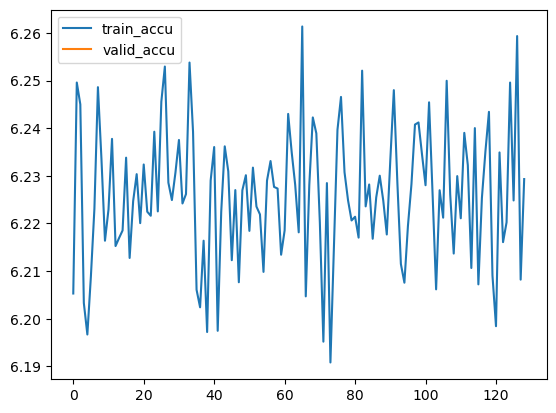

In [26]:
import matplotlib.pyplot as plt
plt.plot(train_accus, label='train_accu')
plt.plot(valid_accus, label='valid_accu')
plt.legend()
plt.show()

In [27]:
# save the model
torch.save(model.state_dict(), "model_transformer_encoder.pt")